# <center> <u> GRU - Rolling Prediction

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv

load_dotenv()

db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [2]:
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [3]:
query="""
    select * 
    from agg.tidy_data_30min
    where site = 64
"""

In [4]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_41285/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [5]:
df = df[['timestamp','net_load']]

In [6]:
df.rename(columns={'timestamp':'ts'},inplace=True)
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)
df.sort_index(inplace=True)
df

,net_load
ts,
2019-04-01 00:00:00+00:00,14.620
2019-04-01 00:30:00+00:00,16.700
2019-04-01 01:00:00+00:00,20.270
2019-04-01 01:30:00+00:00,15.870
2019-04-01 02:00:00+00:00,15.120
...,...
2020-03-31 20:30:00+00:00,14.390
2020-03-31 21:00:00+00:00,14.710
2020-03-31 21:30:00+00:00,14.950


## Normalise the Data

<Axes: xlabel='ts'>

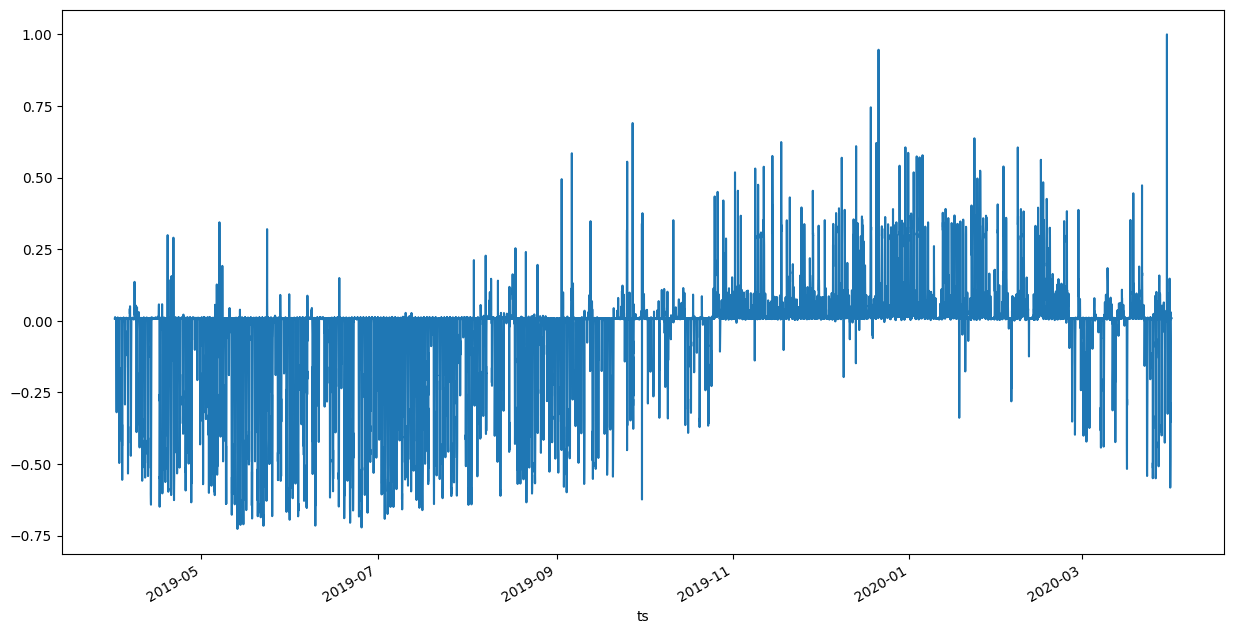

In [7]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))
df.drop('net_load',axis=1,inplace=True)

plt.figure(figsize=(15,8))
df['net_load_norm'].plot()

## Create the Lags and Prepare Data for GRU Model

In [8]:
lags = [1, 2, 48, 96]
for lag in lags:
    df[f'lag_{lag}'] = df['net_load_norm'].shift(lag)

In [9]:
df.dropna(inplace=True)

In [10]:
X = df[['lag_1', 'lag_2', 'lag_48', 'lag_96']].values
y = df['net_load_norm'].values

In [11]:
X_train, X_test = X[:-72], X[-72:]
y_train, y_test = y[:-72], y[-72:]

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import InputLayer, GRU, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error

In [13]:
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(8))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2024-03-28 20:38:48.597417: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-03-28 20:38:48.597445: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-28 20:38:48.597477: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-28 20:38:48.597549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 20:38:48.597576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/adriachimenos/anaconda3/envs/aml_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. W

In [14]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10


2024-03-28 20:38:51.319355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


543/543 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - loss: 0.0074
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - loss: 0.0047
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 0.0043
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - loss: 0.0044
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - loss: 0.0042
Epoch 6/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - loss: 0.0040
Epoch 7/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 0.0038
Epoch 8/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - loss: 0.0036
Epoch 9/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - loss: 0.0037
Epoch 10/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - loss: 0.0038


In [15]:
def get_input(ts, lags):
    # Convert lags to positions from the end of the series
    positions = [-1 - lag for lag in lags]
    # Use numpy indexing to get values at positions
    return ts[positions].reshape(1,len(lags),1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

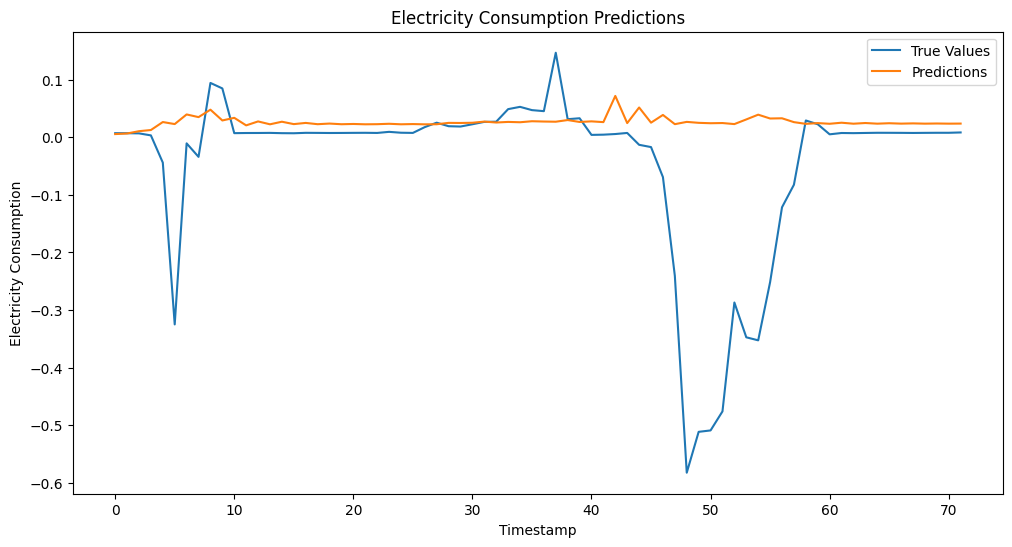

In [16]:
predictions = []
ts = y_train.copy()

# Iterate over each timestamp in the test set
for i in range(len(X_test)):
    x_input = get_input(ts,lags)
    pred_value = model.predict(x_input)
    ts=np.append(ts,pred_value)
    # Store the prediction
    predictions.append(pred_value)

# Convert the list of predictions to numpy array
predictions = np.array(predictions)

# Reshape the predictions array if needed
predictions = predictions.reshape(predictions.shape[0], 1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Timestamp')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption Predictions')
plt.legend()
plt.show()

timeseries
hacer que el test dataset sean los ultimos 30 dias. hacer append de los originales despues de 36 horas y repetir el proceso.

Predecir con la funcion de arriba para 36 horas, y despues añadir.

## Improved Model 2

In [26]:
from keras.layers import GRU, Dense, Reshape
model2 = Sequential()
model2.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model2.add(Reshape((-1, 64)))
model2.add(GRU(32, activation='relu'))
model2.add(Dense(8))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

In [28]:
model2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - loss: 0.0041
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - loss: 0.0038
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - loss: 0.0044
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 0.0036
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0039
Epoch 6/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - loss: 0.0038
Epoch 7/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - loss: 0.0036
Epoch 8/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - loss: 0.0037
Epoch 9/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0036
Epoch 10/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0037


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

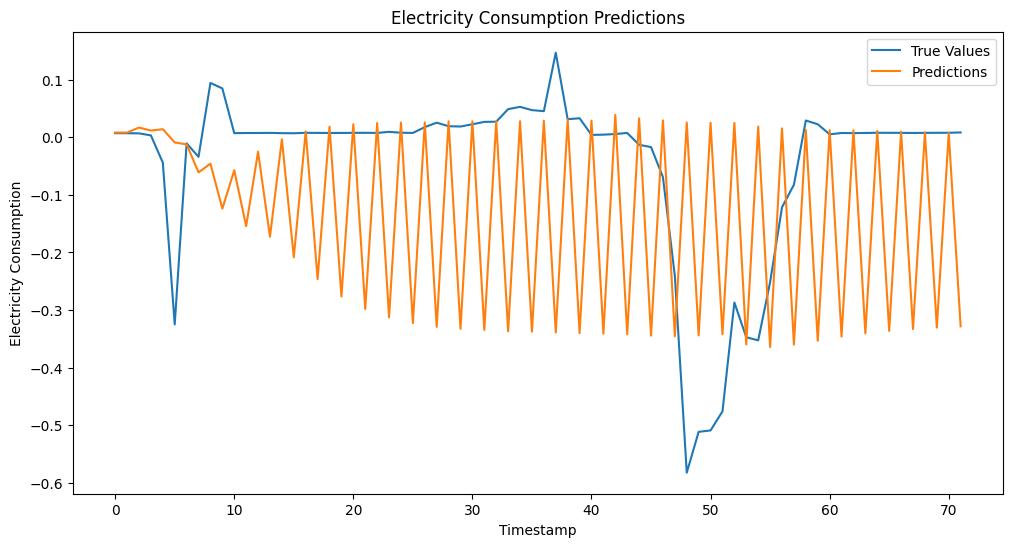

In [29]:
predictions = []
ts = y_train.copy()

# Iterate over each timestamp in the test set
for i in range(len(X_test)):
    x_input = get_input(ts,lags)
    pred_value = model2.predict(x_input)
    ts=np.append(ts,pred_value)
    # Store the prediction
    predictions.append(pred_value)

# Convert the list of predictions to numpy array
predictions = np.array(predictions)

# Reshape the predictions array if needed
predictions = predictions.reshape(predictions.shape[0], 1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Timestamp')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption Predictions')
plt.legend()
plt.show()

## Improved Model 3

In [31]:
model3 = Sequential()
model3.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model3.add(Reshape((-1, 64)))
model3.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model3.add(Dense(8))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')

/Users/adriachimenos/anaconda3/envs/aml_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
model3.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 0.0040
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 0.0041
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 0.0041
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 0.0038
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - loss: 0.0038
Epoch 6/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0036
Epoch 7/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - loss: 0.0037
Epoch 8/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - loss: 0.0038
Epoch 9/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - loss: 0.0038
Epoch 10/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - loss: 0.0038


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

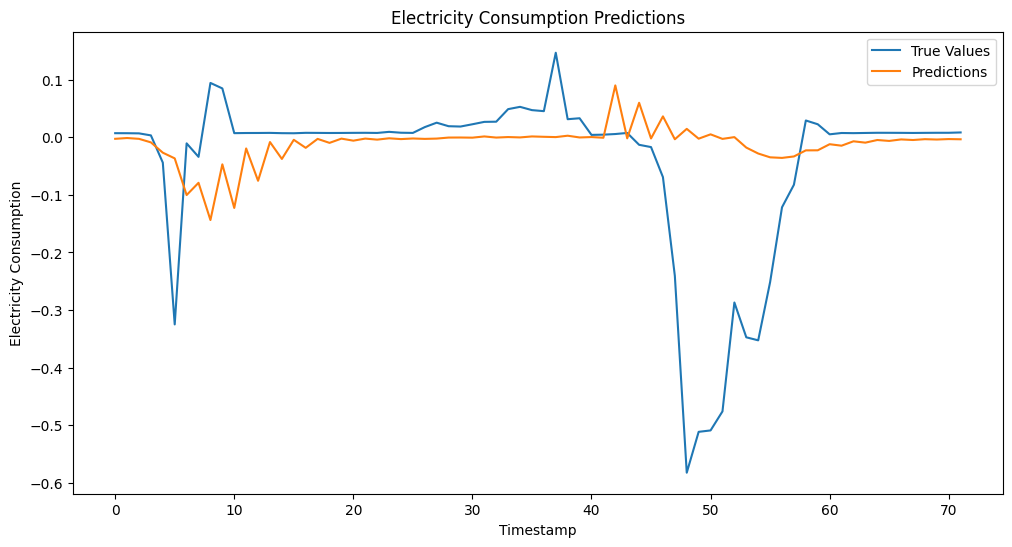

In [34]:
predictions = []
ts = y_train.copy()

# Iterate over each timestamp in the test set
for i in range(len(X_test)):
    x_input = get_input(ts,lags)
    pred_value = model3.predict(x_input)
    ts=np.append(ts,pred_value)
    # Store the prediction
    predictions.append(pred_value)

# Convert the list of predictions to numpy array
predictions = np.array(predictions)

# Reshape the predictions array if needed
predictions = predictions.reshape(predictions.shape[0], 1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Timestamp')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption Predictions')
plt.legend()
plt.show()

## Improved Model 4

In [40]:
model4 = Sequential()
model4.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model3.add(Reshape((-1, 64)))
model4.add(GRU(64, activation='relu'))
model4.add(Dropout(0.2))
model4.add(GRU(32, activation='relu'))
model4.add(Dense(8))
model4.add(Dense(1))
model4.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError(), MeanAbsoluteError()])

ValueError: The total size of the tensor must be unchanged, however, the input size cannot by divided by the specified dimensions in target_shape. Received: input_shape=(1,), target_shape=(-1, 64)

In [ ]:
model4.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# <center> <u> 30 Days Prediction